# Uber: Rush Hour Analaysis for Chelsea Court
#### Chelsea Qiu, June 2019

In [83]:
import os
import re

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sklearn
import matplotlib.pyplot as plt

os.getcwd()

'/Users/chelsea/Python/Uber'

# Read in and Understand data ###

In [84]:
path='/Users/chelsea/Python/Uber/'

driver_trips=pd.read_excel(path+'data_set_170705.xlsx',sheet_name='driver_trips')
rider_trips=pd.read_excel(path+'data_set_170705.xlsx',sheet_name='rider_trips')
driver_data=pd.read_excel(path+'data_set_170705.xlsx',sheet_name='driver_data')
rider_data=pd.read_excel(path+'data_set_170705.xlsx',sheet_name='rider_data')
city_metrics=pd.read_excel(path+'data_set_170705.xlsx',sheet_name='city_metrics')

In [85]:
driver_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59854 entries, 0 to 59853
Data columns (total 9 columns):
trip_id                   59854 non-null object
driver_id                 59854 non-null object
trip_status               59854 non-null object
actual_time_to_arrival    53583 non-null float64
request_time              59854 non-null datetime64[ns]
surge_multiplier          59854 non-null float64
driver payout             59854 non-null float64
start_geo                 59854 non-null object
end_geo                   59854 non-null object
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 4.1+ MB


In [86]:
rider_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 10 columns):
trip_id                      60000 non-null object
rider_id                     60000 non-null object
trip_status                  60000 non-null object
estimated_time_to_arrival    57499 non-null float64
request_time                 60000 non-null datetime64[ns]
surge_multiplier             60000 non-null float64
trip_price_pre_discount      60000 non-null float64
rider_payment                60000 non-null float64
start_geo                    60000 non-null object
end_geo                      60000 non-null object
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 4.6+ MB


In [87]:
driver_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20202 entries, 0 to 20201
Data columns (total 5 columns):
driver_id                   20202 non-null object
first_completed_trip        20202 non-null datetime64[ns]
lifetime_rating             19662 non-null float64
lifetime_fares              20202 non-null float64
lifetime_completed_trips    20202 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 789.2+ KB


In [88]:
rider_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50436 entries, 0 to 50435
Data columns (total 5 columns):
rider_id                50436 non-null object
first_completed_trip    50436 non-null object
lifetime_trips          50430 non-null float64
first_trip_city_id      50436 non-null int64
lifetime_payments       50430 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.9+ MB


In [89]:
city_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 5 columns):
timestamp               672 non-null datetime64[ns]
requests                672 non-null float64
trips                   672 non-null float64
supply_hours            672 non-null float64
mean_surge_multipler    672 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 26.3 KB


#### merge driver_trip and rider_trip together ####

In [90]:
print('driver_trips contains ', driver_trips.trip_id.nunique(), 'unique trips, with ',driver_trips.driver_id.nunique(), ' drivers')
print('rider_trips contains ', rider_trips.trip_id.nunique(), 'unique trips, with ', rider_trips.rider_id.nunique(), ' riders')

driver_trips contains  59853 unique trips, with  20201  drivers
rider_trips contains  59999 unique trips, with  50834  riders


In [91]:
trips=rider_trips.merge(driver_trips, how='outer', on=['trip_id'])
trips.isnull().sum()

trip_id                         0
rider_id                        0
trip_status_x                   0
estimated_time_to_arrival    2502
request_time_x                  0
surge_multiplier_x              0
trip_price_pre_discount         0
rider_payment                   0
start_geo_x                     0
end_geo_x                       0
driver_id                     146
trip_status_y                 146
actual_time_to_arrival       6418
request_time_y                146
surge_multiplier_y            146
driver payout                 146
start_geo_y                   146
end_geo_y                     146
dtype: int64

In [92]:
### check if attributes matches between two tables for a unique trip_id###
trips['missing_flag']=trips['driver payout'].apply(lambda x: 1 if np.isnan(x) else 0)
trips.missing_flag.sum()

146

In [93]:
a=trips.eval("""missing_flag==0""")
check=trips.loc[a]
check.status_match=check.apply(lambda x: 1 if x.trip_status_x==x.trip_status_y else 0, axis=1)
check.time_match=check.apply(lambda x: 1 if x.request_time_x==x.request_time_y else 0, axis=1)
check.surge_match=check.apply(lambda x: 1 if x.surge_multiplier_x==x.surge_multiplier_y else 0, axis=1)
check.start_match=check.apply(lambda x: 1 if x.start_geo_x==x.start_geo_y else 0, axis=1)
check.end_match=check.apply(lambda x: 1 if x.end_geo_x==x.end_geo_y else 0, axis=1)

###check match rate###
print("status match rate: % .1f" % (check.status_match.sum()/check.trip_id.nunique()))
print("time match rate: % .1f" % (check.time_match.sum()/check.trip_id.nunique()))
print("surge match rate: % .1f" % (check.time_match.sum()/check.trip_id.nunique()))
print("start location match rate: % .1f" % (check.time_match.sum()/check.trip_id.nunique()))
print("end location match rate: % .1f" % (check.time_match.sum()/check.trip_id.nunique()))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/st

status match rate:  1.0
time match rate:  1.0
surge match rate:  1.0
start location match rate:  1.0
end location match rate:  1.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


In [94]:
### Only need to keep valid information from driver trip data
driver_trips2=driver_trips[['trip_id','driver_id','actual_time_to_arrival','driver payout']]
trips=rider_trips.merge(driver_trips2, on =['trip_id'], how='left')
trips.head()

,trip_id,rider_id,trip_status,estimated_time_to_arrival,request_time,surge_multiplier,trip_price_pre_discount,rider_payment,start_geo,end_geo,driver_id,actual_time_to_arrival,driver payout
0,b3cb-b9bf,5ba9-cd29,completed,4.483333,2012-04-09 06:12:00,1.0,5.296,5.296,Allen Abby,Chelsea Court,4649-2f0a,3.516667,4.2368
1,8569-0fbf,b8ed-f739,completed,4.683333,2012-05-06 05:44:00,2.0,10.304,10.304,Blair Bend,Chelsea Court,4003-e2e7,2.633333,8.2432
2,86f2-e4cc,a12d-275f,completed,1.983333,2012-04-25 11:28:00,1.0,7.744,7.744,Chelsea Court,Blair Bend,44af-7b74,1.333333,6.1952
3,aef6-924e,14af-2a91,completed,2.750000,2012-04-27 21:34:00,1.0,10.232,10.232,Chelsea Court,Daisy Drive,4909-aa90,1.700000,8.1856
4,921a-11d3,a0b5-fbfc,completed,NaN,2012-04-30 16:44:00,1.0,14.760,14.760,Daisy Drive,Daisy Drive,4e79-a40f,NaN,11.8080


In [95]:
trips.describe()

,estimated_time_to_arrival,surge_multiplier,trip_price_pre_discount,rider_payment,actual_time_to_arrival,driver payout
count,57500.000000,60002.000000,60002.000000,60002.000000,53584.000000,59856.000000
mean,3.270889,1.158858,7.600955,7.550875,2.674936,6.095596
std,2.148811,0.335810,6.026312,6.002778,2.585225,4.817551
min,0.016667,1.000000,0.000000,0.000000,0.016667,0.000000
25%,1.733333,1.000000,5.296000,5.296000,0.800000,4.236800
50%,2.833333,1.000000,6.168000,6.120000,1.966667,4.940800
75%,4.333333,1.200000,8.808000,8.704600,3.816667,7.059200
max,53.416667,4.800000,219.832000,219.832000,70.316667,175.865600


In [96]:
## missing value check ##
trips.isnull().sum()/trips.count()

trip_id                      0.000000
rider_id                     0.000000
trip_status                  0.000000
estimated_time_to_arrival    0.043513
request_time                 0.000000
surge_multiplier             0.000000
trip_price_pre_discount      0.000000
rider_payment                0.000000
start_geo                    0.000000
end_geo                      0.000000
driver_id                    0.002439
actual_time_to_arrival       0.119775
driver payout                0.002439
dtype: float64

### Time Stamp ###

In [97]:
import datetime
from datetime import date

In [98]:
def sort_weekday(x):
    if x=='Monday':
        y='1.MON'
    elif x=='Tuesday':
        y='2.TUE'
    elif x=='Wednesday':
        y='3.WED'
    elif x=='Thursday':
        y='4.THUR'
    elif x=='Friday':
        y='5.FRI'
    elif x=='Saturday':
        y='6.SAT'
    else:
        y='7.SUN'
    return y

trips['year']=trips['request_time'].apply(lambda x: x.year)
trips['month']=trips['request_time'].apply(lambda x: x.month)
trips['day']=trips['request_time'].apply(lambda x: x.day)
trips['hour']=trips['request_time'].apply(lambda x: x.hour)
trips['weekday']=trips['request_time'].apply(lambda x: x.weekday_name)
daylist=['Monday','Tuesday','Wednesday','Thursday','Friday']
trips['is_weekday']=trips['weekday'].apply(lambda x: 1 if x in daylist else 0)
trips['weekday']=trips['weekday'].apply(sort_weekday)

trips[['request_time','year','month','day','hour','weekday','is_weekday']].head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead


,request_time,year,month,day,hour,weekday,is_weekday
0,2012-04-09 06:12:00,2012,4,9,6,1.MON,1
1,2012-05-06 05:44:00,2012,5,6,5,7.SUN,0
2,2012-04-25 11:28:00,2012,4,25,11,3.WED,1
3,2012-04-27 21:34:00,2012,4,27,21,5.FRI,1
4,2012-04-30 16:44:00,2012,4,30,16,1.MON,1


In [99]:
trips['ETA_na_flag']=trips.estimated_time_to_arrival.apply(lambda x: 1 if np.isnan(x) or x==0 else 0)
trips['ATA_na_flag']=trips.actual_time_to_arrival.apply(lambda x: 1 if np.isnan(x) or x==0 else 0)
trips.groupby(['trip_status']).agg({'trip_id':['nunique'], 'ETA_na_flag':['sum'], 'ATA_na_flag':['sum']})
trips['ETA_error']=trips.estimated_time_to_arrival-trips.actual_time_to_arrival

In [100]:
#will drop ETA_na_flag ==1 or ATA_na_flag ==1 in completed trips for analysis
trips['request_in']=1
trips['complete_trips']=trips['trip_status'].apply(lambda x: 1 if x=='completed' else 0)
trips['cancelled_trips']=trips['trip_status'].apply(lambda x: 1 if x=='rider_canceled' else 0)

### inbond CC and Outbond CC, and trips not realated to Chelsea Court
trips['CC_outbound']=trips['start_geo'].apply(lambda x: 1 if x=='Chelsea Court' else 0)
trips['CC_inbound']=trips['end_geo'].apply(lambda x: 1 if x=='Chelsea Court' else 0)
trips['CC_flag']=trips.apply(lambda x: max(x.CC_inbound,x.CC_outbound), axis=1)
trips[['start_geo','end_geo','CC_flag','CC_inbound','CC_outbound']].head()

,start_geo,end_geo,CC_flag,CC_inbound,CC_outbound
0,Allen Abby,Chelsea Court,1,1,0
1,Blair Bend,Chelsea Court,1,1,0
2,Chelsea Court,Blair Bend,1,0,1
3,Chelsea Court,Daisy Drive,1,0,1
4,Daisy Drive,Daisy Drive,0,0,0


#### Indicators ###

In [148]:
complete=trips.eval("""trip_status=='completed'""")
cancel= trips.eval("""trip_status=='rider_canceled'""")
cc= trips.eval("""CC_flag==1""")
ata_na=trips.eval("""ATA_na_flag==1""")
eta_na=trips.eval("""ETA_na_flag==1""")
w=trips.eval("""is_weekday==1""")

In [149]:
trips.groupby(['trip_status']).agg({'trip_id':['nunique'], 'ETA_na_flag':['sum'],'ATA_na_flag':['sum']})

,trip_id,ETA_na_flag,ATA_na_flag
,nunique,sum,sum
trip_status,,,
completed,54139,2210,2408
failed,49,29,29
rider_canceled,5777,227,3946
unfulfilled,35,36,35


### Average Statistics

In [103]:
print("CC Completed Trips average ETA:" , trips.loc[cc&~eta_na&complete].estimated_time_to_arrival.mean(), "mins")
print("CC Incomplete Trips average ETA:" , trips.loc[cc&~eta_na&~complete].estimated_time_to_arrival.mean(), "mins")
print("CC Completed Trips average ETA Error:" , trips.loc[cc&~eta_na&complete].ETA_error.mean(), "mins")
print("CC Incomplete Trips average ETA Error:" , trips.loc[cc&~eta_na&~complete].ETA_error.mean(), "mins")

CC Completed Trips average ETA: 3.0797425565260026 mins
CC Incomplete Trips average ETA: 4.5355984740116755 mins
CC Completed Trips average ETA Error: 0.4343935852800985 mins
CC Incomplete Trips average ETA Error: 1.1136518356002938 mins


In [104]:
print("Completed Trips CC:" , trips.loc[cc&complete].complete_trips.sum())
print("Completed Trips City (in Trips data):" , trips.loc[complete].complete_trips.sum())
print("Completed Trips City (in City Metrics)", city_metrics.trips.sum())
print("Non CC trips is under represented in the Trips Data Set")

Completed Trips CC: 46328
Completed Trips City (in Trips data): 54140
Completed Trips City (in City Metrics) 65931.76485174504
Non CC trips is under represented in the Trips Data Set


### Observation: ETA for completed and canncelled trips are totally different distribution ###

## Cleaning trips dataset for Chelsea Court

1. For incompleted trips, ATA might be null by default
2. For completed trips, exclude the trips when ETA or ATA is null
3. Include trips Outbound from Chelsea Court Only

In [105]:
### For Chelsea Court
clean_trips=trips.loc[cc&~eta_na&~ata_na]
### For city
trips_all=trips.loc[~eta_na&~ata_na]

# Aggregated To Hourly Level: for Definition of Rush Hour

##### To investigate if surge multiplier is efficient in Chelsea Court

In [106]:
## Summary for CC only
### do not need to remove ETA or ATA missing data for general summary 

sum_attr=['request_in','complete_trips','cancelled_trips']
group_var=['year','month','day','weekday','is_weekday','hour']
mean_att=['surge_multiplier','estimated_time_to_arrival','actual_time_to_arrival','ETA_error']

trip_sum=trips[cc].groupby(group_var, as_index=False)[sum_attr].sum()
trip_mean=trips[cc].groupby(group_var, as_index=False)[mean_att].mean()

trip_summary=trip_sum.merge(trip_mean, on=group_var, how='inner')
trip_summary['supply_gap']=trip_summary['request_in']-trip_summary['complete_trips']
trip_summary['complete_rate']=trip_summary['complete_trips']/trip_summary['request_in']
trip_summary['cancel_rate']=trip_summary['cancelled_trips']/trip_summary['request_in']

trip_summary[mean_att+sum_attr].describe()

,surge_multiplier,estimated_time_to_arrival,actual_time_to_arrival,ETA_error,request_in,complete_trips,cancelled_trips
count,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.00000
mean,1.161803,3.281909,2.687807,0.465483,75.566319,69.043219,6.42921
std,0.208730,0.775540,0.759946,0.385348,46.490936,42.692440,5.08442
min,1.000000,1.274074,0.562963,-1.500000,1.000000,1.000000,0.00000
25%,1.010000,2.764449,2.212276,0.237507,30.500000,28.500000,2.00000
50%,1.078182,3.196244,2.638314,0.457377,79.000000,73.000000,6.00000
75%,1.239884,3.700538,3.096839,0.698438,106.000000,97.000000,9.00000
max,2.746094,8.883333,6.018750,1.761905,207.000000,196.000000,32.00000


### Distribution for Hourly Request, Hourly Supply Gap, Hourly Mean Surge Multiplier

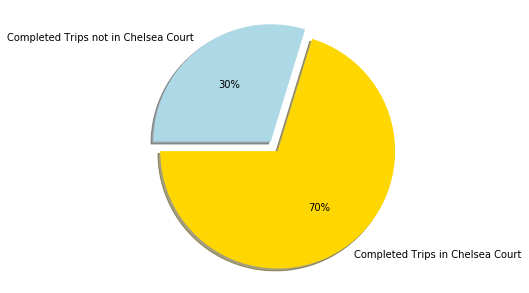

In [107]:
### Trips
plt.figure(figsize=(6,5))
labels = ['Completed Trips in Chelsea Court', 'Completed Trips not in Chelsea Court']
sizes = [trip_summary.complete_trips.sum(),city_metrics.trips.sum()-trip_summary.complete_trips.sum()]
colors = ['gold', 'lightblue']
explode = (0.1, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.0f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: T

Text(0.5,0,'Average Trip ETA error')

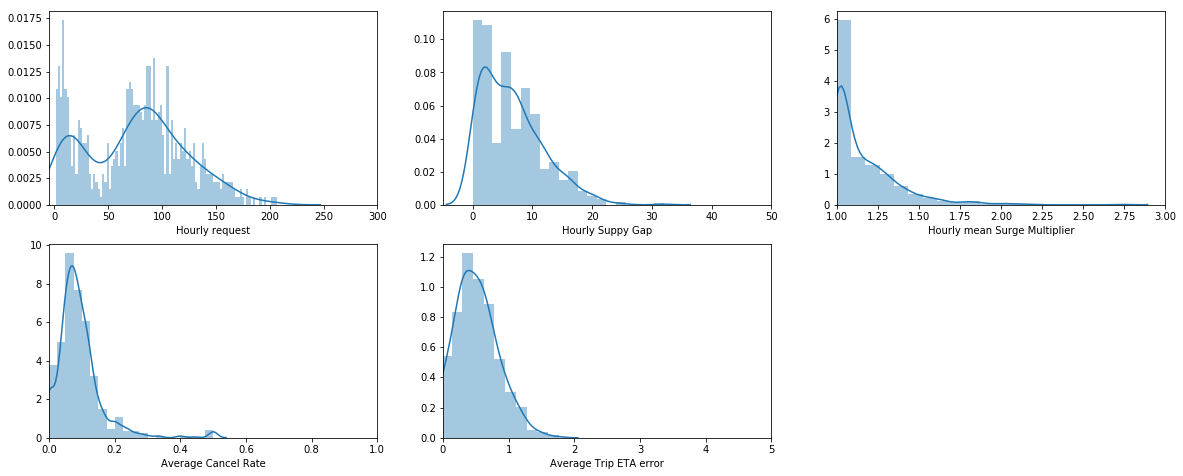

In [108]:
plt.figure(figsize=(20, 25))

plt.subplot(631)
plt.xlim(-5,300)
a1=sns.distplot(trip_summary.request_in,bins=100)
plt.xlabel('Hourly request')

plt.subplot(632)
plt.xlim(-5,50)
a1=sns.distplot(trip_summary.supply_gap,bins=20)
plt.xlabel('Hourly Suppy Gap')

plt.subplot(633)
plt.xlim(1,3)
a3=sns.distplot(trip_summary.surge_multiplier, bins=20)
plt.xlabel('Hourly mean Surge Multiplier')

plt.subplot(634)
plt.xlim(0,1)
a3=sns.distplot(trip_summary.cancel_rate, bins=20)
plt.xlabel('Average Cancel Rate')

plt.subplot(635)
plt.xlim(0,5)
a3=sns.distplot(trip_summary.ETA_error, bins=20)
plt.xlabel('Average Trip ETA error')

### Definition Rush Hours

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Hourly Request Distribution in Chelsea Court')

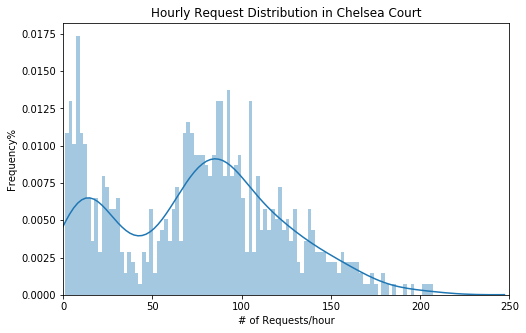

In [109]:
plt.figure(figsize=(8, 5))
plt.xlim(0,250)
ax=sns.distplot(trip_summary.request_in,bins=100,label='Chelsea Court')
plt.xlabel('# of Requests/hour')
plt.ylabel('Frequency%')
plt.title('Hourly Request Distribution in Chelsea Court')

In [110]:
## Cut Quantiles
q1=trip_summary.request_in.quantile(0.05)
q2=trip_summary.request_in.quantile(0.5)
q3=trip_summary.request_in.quantile(0.80)
q4=trip_summary.request_in.quantile(0.95)
max1=trip_summary.request_in.max()
min1=trip_summary.request_in.min()
bins_list=[min1,q1,q2,q3,q4,max1]
print(bins_list)

[1, 6.0, 79.0, 115.0, 153.5, 207]


### Take 85% Quantile as the cut off of the Rush Hour

In [111]:
q=trip_summary.request_in.quantile(0.85)
print("Rush Hour Cut-off: Hourly Request >= ", q)
trip_summary['new_rush_hour']=trip_summary.request_in.apply(lambda x: 1 if x>=120 else 0)
rush_hour=trip_summary[['new_rush_hour','year','month','day','hour']]
trips=trips.merge(rush_hour, on=['year','month','day','hour'], how='inner')

Rush Hour Cut-off: Hourly Request >=  123.5


Text(0.5,1,'Rush Hour Heat Map in Chelsea Court')

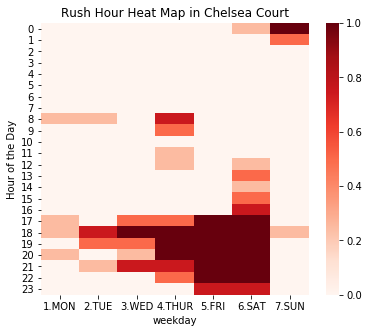

In [112]:
new=trip_summary.groupby(['weekday','hour'], as_index=False)['new_rush_hour','request_in','surge_multiplier','supply_gap','cancel_rate','ETA_error'].mean()
new['rush_hour_in']=new['new_rush_hour'].apply(lambda x: 1 if x>=0.6 else 0)
plt.figure(figsize=(6,5))
new2= pd.pivot_table(new, values=['new_rush_hour'], index=['hour'],columns=['weekday'])
new2.columns=new2.columns.droplevel(level=0)
sns.heatmap(new2,cmap="Reds")
plt.ylabel('Hour of the Day')
plt.title('Rush Hour Heat Map in Chelsea Court')

Text(0.5,1,'Average Surge Multiplier in Chelsea Court')

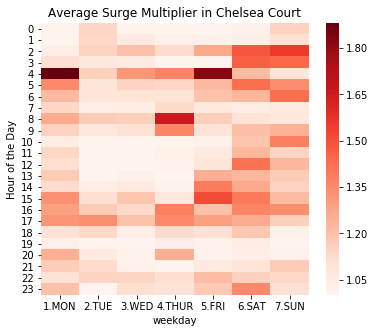

In [113]:
plt.figure(figsize=(6,5))
new3= pd.pivot_table(new, values=['surge_multiplier'], index=['hour'],columns=['weekday'])
new3.columns=new3.columns.droplevel(level=0)
sns.heatmap(new3,cmap="Reds")
plt.ylabel('Hour of the Day')
plt.title('Average Surge Multiplier in Chelsea Court')

Text(0.5,1,'Average Supply Gap by Hourly Schedule in Chelsea Court')

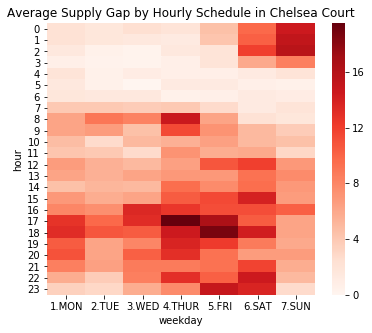

In [114]:
plt.figure(figsize=(6,5))
new3= pd.pivot_table(new, values=['supply_gap'], index=['hour'],columns=['weekday'])
new3.columns=new3.columns.droplevel(level=0)
sns.heatmap(new3,cmap="Reds")
plt.title('Average Supply Gap by Hourly Schedule in Chelsea Court')

## Diagnose 1
### Inefficient Surge Multiplier in Chelsea Court that creates Supply Gap

### Exam relationship between Surge Multiplier, Request, Supply Gap, and Cancel Rate

Text(0.5,1,'Relationship between Surge Multiplier and Requests')

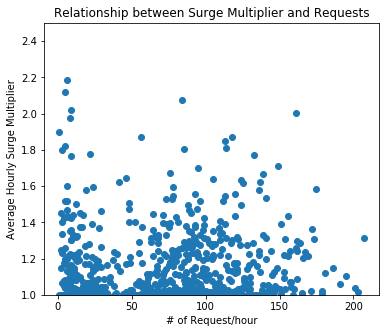

In [115]:
plt.figure(figsize=(6,5))
g = plt.scatter(x="request_in", y="surge_multiplier", data=trip_summary)
plt.ylim(1,2.5)
plt.xlabel("# of Request/hour")
plt.ylabel("Average Hourly Surge Multiplier")
plt.title('Relationship between Surge Multiplier and Requests')

Text(0.5,1,'Relationship between Surge Multiplier and Supply Gap')

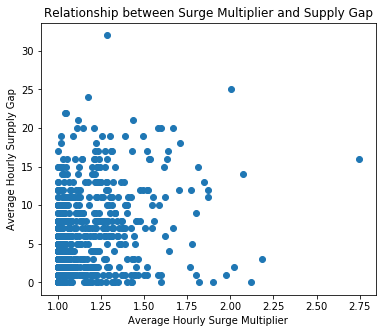

In [116]:
plt.figure(figsize=(6,5))
g = plt.scatter(x="surge_multiplier", y="supply_gap", data=trip_summary)
plt.ylabel("Average Hourly Surpply Gap")
plt.xlabel("Average Hourly Surge Multiplier")
plt.title('Relationship between Surge Multiplier and Supply Gap')

Text(0.5,1,'Relationship between Surge Multiplier and Cancellation')

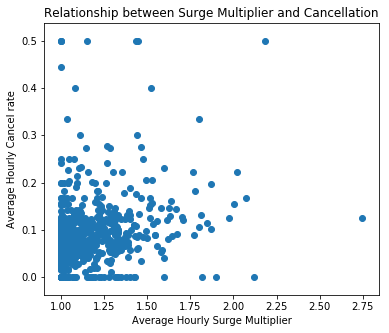

In [117]:
plt.figure(figsize=(6,5))
g = plt.scatter(x="surge_multiplier", y="cancel_rate",data=trip_summary)

plt.xlabel("Average Hourly Surge Multiplier")
plt.ylabel("Average Hourly Cancel rate")
plt.title('Relationship between Surge Multiplier and Cancellation')

                           estimated_time_to_arrival  actual_time_to_arrival
estimated_time_to_arrival                   1.000000                0.826133
actual_time_to_arrival                      0.826133                1.000000


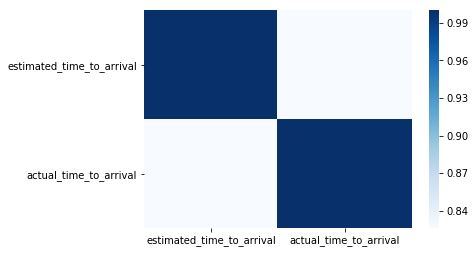

In [118]:
corr=trip_summary[['estimated_time_to_arrival','actual_time_to_arrival']].corr()
print(corr)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="Blues")

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Cancel Rate % Distribution for Chelse Court')

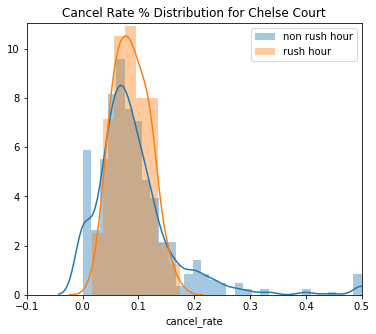

In [119]:
rush=trip_summary.eval("""new_rush_hour==1""")
plt.figure(figsize=(6, 5))
plt.xlim(-0.1,0.5)
sns.distplot(trip_summary.loc[~rush].cancel_rate, label='non rush hour')
sns.distplot(trip_summary.loc[rush].cancel_rate, label='rush hour')

plt.legend()
plt.title('Cancel Rate % Distribution for Chelse Court')

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Average Surge Multiplier Distribution for Chelsea Court')

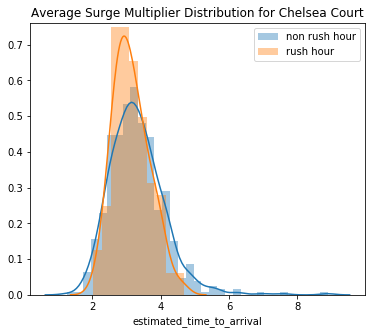

In [120]:
rush=trip_summary.eval("""new_rush_hour==1""")
plt.figure(figsize=(6, 5))

sns.distplot(trip_summary.loc[~rush].estimated_time_to_arrival, label='non rush hour')
sns.distplot(trip_summary.loc[rush].estimated_time_to_arrival, label='rush hour')

plt.legend()
plt.title('Average Surge Multiplier Distribution for Chelsea Court')

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0, 0.15)

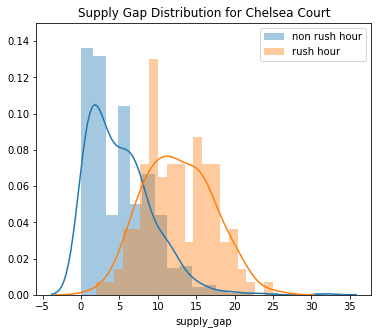

In [121]:
rush=trip_summary.eval("""new_rush_hour==1""")
plt.figure(figsize=(6, 5))

sns.distplot(trip_summary.loc[~rush].supply_gap, bins=20,label='non rush hour')
sns.distplot(trip_summary.loc[rush].supply_gap, bins=20, label='rush hour')
plt.legend()
plt.title('Supply Gap Distribution for Chelsea Court')
plt.ylim(0,0.15)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Cancel Rate % Distribution for Chelse Court')

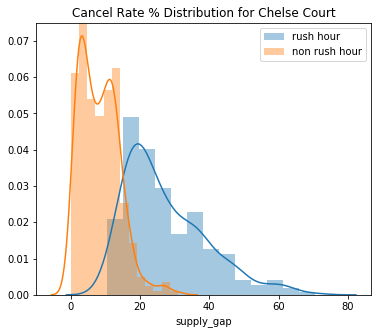

In [122]:
rush=city_summary.eval("""city_rush_hour==1""")
plt.figure(figsize=(6, 5))
sns.distplot(city_summary.loc[rush].supply_gap, label='rush hour')
sns.distplot(city_summary.loc[~rush].supply_gap, label='non rush hour')
plt.legend()
plt.title('Cancel Rate % Distribution for Chelse Court')

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Cancel Rate % Distribution for Chelse Court')

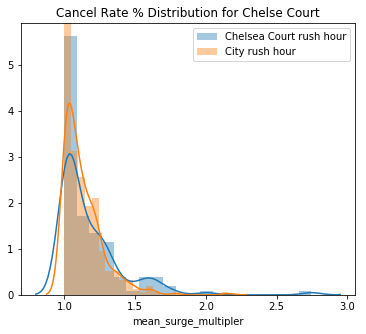

In [123]:
rush=trip_summary.eval("""new_rush_hour==1""")
rush2=city_summary.eval("""city_rush_hour==1""")
plt.figure(figsize=(6, 5))
sns.distplot(trip_summary.loc[rush].surge_multiplier, label='Chelsea Court rush hour')
sns.distplot(city_summary.loc[rush2].mean_surge_multipler, label='City rush hour')
plt.legend()
plt.title('Cancel Rate % Distribution for Chelse Court')

In [124]:
trip_summary.groupby(['new_rush_hour']).surge_multiplier.mean()

new_rush_hour
0    1.157691
1    1.180687
Name: surge_multiplier, dtype: float64

## Diagnose 2: ETA and ETA Error Might be the Reason that Riders Cancellation

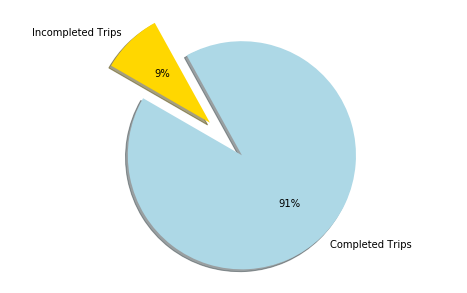

In [125]:
labels = ['Completed Trips', 'Incompleted Trips']
sizes = [trip_summary.complete_trips.sum(),trip_summary.request_in.sum()-trip_summary.complete_trips.sum()]
colors = ['lightblue', 'gold']
explode = (0.4, 0)  # explode 1st slice
plt.figure(figsize=(8,5))
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.0f%%', shadow=True, startangle=150)
plt.axis('equal')
plt.show()

Text(0.5,0,'Estimated Time To Arrival (mins)')

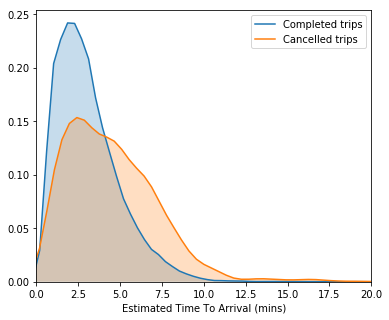

In [150]:
### Print out the distribution to make sure they are aligned ###
### Over all ###

plt.figure(figsize=(6, 5))
plt.xlim(0,20)
sns.kdeplot(trips.loc[cc&~eta_na&complete].estimated_time_to_arrival,shade=True, label="Completed trips")
sns.kdeplot(trips.loc[cc&~eta_na&~complete].estimated_time_to_arrival, shade=True,label="Cancelled trips")
plt.xlabel('Estimated Time To Arrival (mins)')

Text(0.5,0,'Estimated Time To Arrival (mins) - hourly average')

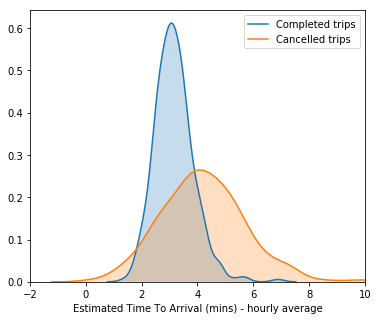

In [151]:
### Print out the distribution to make sure they are aligned ###
### Over all ###
group_var=['month','day','hour']
plt.figure(figsize=(6, 5))
plt.xlim(-2,10)
sns.kdeplot(trips.loc[cc&~eta_na&complete].groupby(group_var).estimated_time_to_arrival.mean(),shade=True, label="Completed trips")
sns.kdeplot(trips.loc[cc&~eta_na&~complete].groupby(group_var).estimated_time_to_arrival.mean(), shade=True,label="Cancelled trips")
plt.xlabel('Estimated Time To Arrival (mins) - hourly average')

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5,0,'ETA Error (mins) - hourly average')

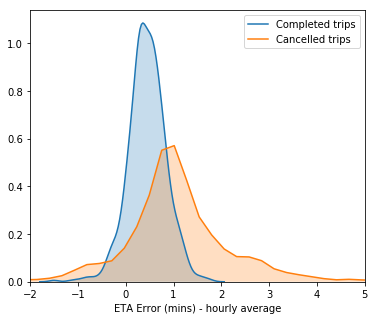

In [153]:
### Print out the distribution to make sure they are aligned ###
### Over all ###
group_var=['month','day','hour']
plt.figure(figsize=(6, 5))
plt.xlim(-2,5)
sns.kdeplot(trips.loc[cc&~eta_na&complete].groupby(group_var).ETA_error.mean(),shade=True, label="Completed trips")
sns.kdeplot(trips.loc[cc&~eta_na&~complete].groupby(group_var).ETA_error.mean(), shade=True,label="Cancelled trips")
plt.xlabel('ETA Error (mins) - hourly average')

## Benchmarking: City Metrics Data

In [154]:
def sort_weekday(x):
    if x=='Monday':
        y='1.MON'
    elif x=='Tuesday':
        y='2.TUE'
    elif x=='Wednesday':
        y='3.WED'
    elif x=='Thursday':
        y='4.THUR'
    elif x=='Friday':
        y='5.FRI'
    elif x=='Saturday':
        y='6.SAT'
    else:
        y='7.SUN'
    return y

city_metrics['year']=city_metrics['timestamp'].apply(lambda x: x.year)
city_metrics['month']=city_metrics['timestamp'].apply(lambda x: x.month)
city_metrics['day']=city_metrics['timestamp'].apply(lambda x: x.day)
city_metrics['hour']=city_metrics['timestamp'].apply(lambda x: x.hour)
city_metrics['weekday']=city_metrics['timestamp'].apply(lambda x: x.weekday_name)
daylist=['Monday','Tuesday','Wednesday','Thursday','Friday']
city_metrics['is_weekday']=city_metrics['weekday'].apply(lambda x: 1 if x in daylist else 0)
city_metrics['weekday']=city_metrics['weekday'].apply(sort_weekday)
city_metrics['supply_gap']=city_metrics.requests-city_metrics.trips
city_summary=city_metrics
city_metrics.isnull().sum()/city_metrics.count()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead


timestamp               0.0
requests                0.0
trips                   0.0
supply_hours            0.0
mean_surge_multipler    0.0
year                    0.0
month                   0.0
day                     0.0
hour                    0.0
weekday                 0.0
is_weekday              0.0
supply_gap              0.0
city_rush_hour          0.0
dtype: float64

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


Text(0.5,0,'Number of Requests')

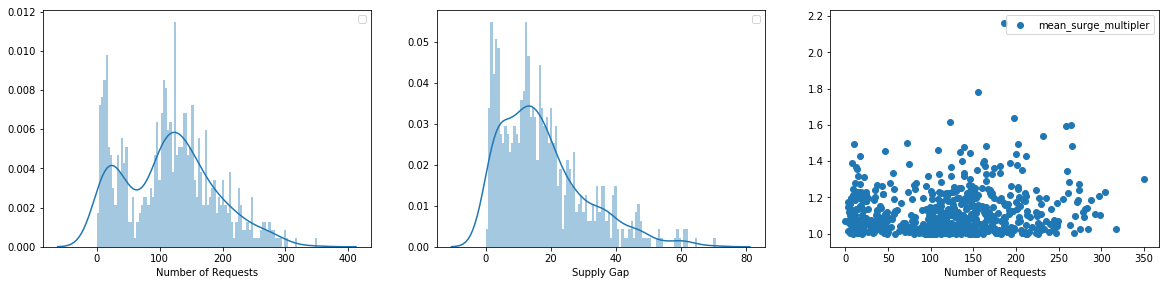

In [155]:
## Overall distribution of City Statistics
plt.figure(figsize=(20, 20))

plt.subplot(431)
sns.distplot(city_summary.requests,bins=100)
plt.legend()
plt.xlabel('Number of Requests')

plt.subplot(432)
sns.distplot(city_summary.supply_gap,bins=100)
plt.legend()
plt.xlabel('Supply Gap')

plt.subplot(433)
plt.scatter(x='requests', y='mean_surge_multipler', data=city_summary)
plt.legend()
plt.xlabel('Number of Requests')

#### Some Stats for City Metrics and Chelsea Court

In [131]:
print(trip_summary.year.unique())
print(trip_summary.month.unique())
print(trip_summary.day.unique())

[2012]
[4 5]
[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30  1  2
  3  4  5  6]


In [132]:
print('Total Requests in City during observed time period:', city_metrics.requests.sum())
print('Total Requests in Chelsea Court: ', trip_summary.request_in.sum())
print('Chelsea Court Requests makes up ', trip_summary.request_in.sum()/city_metrics.requests.sum()*100,"% of Total City Requests" )

Total Requests in City during observed time period: 77653.81814165978
Total Requests in Chelsea Court:  50705
Chelsea Court Requests makes up  65.29620978520533 % of Total City Requests


In [133]:
print('Total Completed Trips in City:', city_metrics.trips.sum())
print('Total Completed Trips in Chelsea Court: ', trip_summary.complete_trips.sum())
print('Chelsea Court Completed makes up ', trip_summary.complete_trips.sum()/city_metrics.trips.sum()*100,"% of Total City Completed" )

Total Completed Trips in City: 65931.76485174504
Total Completed Trips in Chelsea Court:  46328
Chelsea Court Completed makes up  70.26658561950177 % of Total City Completed


In [134]:
april=trip_summary.loc[trip_summary['month']==4].request_in.mean()
may=trip_summary.loc[trip_summary['month']==5].request_in.mean()
print("MoM request growth: ", (may/april-1)*100, "%")
print(april, may)

MoM request growth:  10.423005975373268 %
73.92424242424242 81.62937062937063


In [135]:
april=trip_summary.loc[trip_summary['month']==4].complete_trips.mean()
may=trip_summary.loc[trip_summary['month']==5].complete_trips.mean()
print("MoM trip growth: ", (may/april-1)*100, "%")
print(april, may)

MoM trip growth:  11.051212938005396 %
67.45454545454545 74.9090909090909


In [136]:
april=city_metrics.loc[city_metrics['month']==4].trips.mean()
may=city_metrics.loc[city_metrics['month']==5].trips.mean()
print("MoM trip growth: ", (may/april-1)*100, "%")
print(april, may)

MoM trip growth:  10.61441985142244 %
95.93078189570488 106.11327785286736


In [137]:
april=city_metrics.loc[city_metrics['month']==4].requests.mean()
may=city_metrics.loc[city_metrics['month']==5].requests.mean()
print("MoM trip growth: ", (may/april-1)*100, "%")
print(april, may)

MoM trip growth:  10.780155474002285 %
112.9471599718528 125.1230394202886


Text(0.5,1,'Rush Hour (Possibility) Heat Map in City')

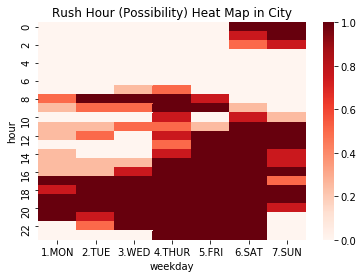

In [138]:
q2=120
city_summary['city_rush_hour']=city_summary.requests.apply(lambda x: 1 if x>=q2 else 0)

new=city_summary.groupby(['weekday','hour'], as_index=False)['city_rush_hour','requests','mean_surge_multipler','supply_gap','trips'].mean()
new2= pd.pivot_table(new, values=['city_rush_hour'], index=['hour'],columns=['weekday'])
new2.columns=new2.columns.droplevel(level=0)
sns.heatmap(new2,cmap="Reds")
plt.title('Rush Hour (Possibility) Heat Map in City')

Text(0.5,1,'Average Surge Multiplier Heat Map in City')

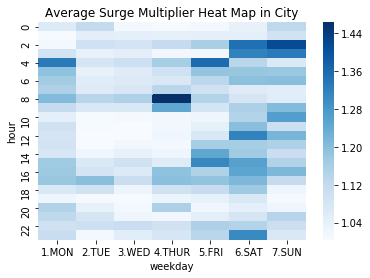

In [139]:
## choose Option 2: Re-define rush hour for CC only
new2= pd.pivot_table(new, values=['mean_surge_multipler'], index=['hour'],columns=['weekday'])
new2.columns=new2.columns.droplevel(level=0)
sns.heatmap(new2,cmap="Blues")
plt.title('Average Surge Multiplier Heat Map in City')

Text(0.5,1,'Rush Hour (Possibility) Heat Map in City -- City Rush Hour')

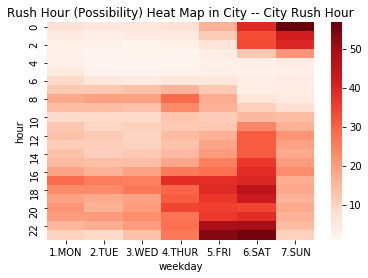

In [140]:
## choose Option 2: Re-define rush hour for CC only
new2= pd.pivot_table(new, values=['supply_gap'], index=['hour'],columns=['weekday'])
new2.columns=new2.columns.droplevel(level=0)
sns.heatmap(new2,cmap="Reds")
plt.title('Rush Hour (Possibility) Heat Map in City -- City Rush Hour')

Text(0.5,1,'Average Requests Heat Map in City')

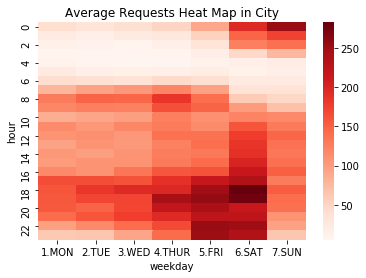

In [141]:
## choose Option 2: Re-define rush hour for CC only
new2= pd.pivot_table(new, values=['requests'], index=['hour'],columns=['weekday'])
new2.columns=new2.columns.droplevel(level=0)
sns.heatmap(new2,cmap="Reds")
plt.title('Average Requests Heat Map in City')

In [142]:
### Rush hour average for City overall
city_rush_hour=city_summary.groupby(['city_rush_hour'])['requests','mean_surge_multipler','supply_gap','trips'].mean()
city_rush_hour

,requests,mean_surge_multipler,supply_gap,trips
city_rush_hour,,,,
0,59.794786,1.091552,8.308386,51.486400
1,175.806310,1.131420,27.314015,148.492295


In [143]:
### Rush hour average for Chelsea Court
cc_rush_hour=trip_summary.groupby(['new_rush_hour'])['request_in','surge_multiplier','supply_gap'].mean()
cc_rush_hour

,request_in,surge_multiplier,supply_gap
new_rush_hour,,,
0,60.675136,1.157691,5.190563
1,143.941667,1.180687,12.641667
